In [4]:
from function_bank import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 20
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [5]:
class tabletDataset:
    def __init__(self, data, name, dep_var):
        self.name = name
        self.cp40 = data[data['CP']==40]
        self.y = self.cp40[dep_var]
        self.x = 'Not configured'
        self.train_x = 'Not configured'
        self.train_y = 'Not configured'
        self.val_x = 'Not configured'
        self.val_y = 'Not configured'
        self.valtrain_x = 'Not configured'
        self.valtrain_y = 'Not configured'
        self.test_x = 'Not configured'
        self.test_y = 'Not configured'
    
    
    def prepare_independent_vars(self, relevant_vars, categorical_vars):
        self.x = self.cp40[relevant_vars]
        
        def cat_var_to_onehot_encoded(df, col):
            series = df[col]
            one_hot = pd.get_dummies(series)
            df = pd.concat([df, one_hot], axis=1)
            df = df.drop(col, axis = 1)
            return df
        
        if len(categorical_vars) > 0:
            for i in categorical_vars:
                self.x = cat_var_to_onehot_encoded(self.x, i)
            print(self.name + ": Independent variables indentified, categorical variables one-hot encoded.")
                
        else:
            print(self.name + ": Independent variables indentified, no categorical variables to encode.")
            
            
#     def prepare_train_test(self):
#         self.train_x, self.test_x, self.train_y, self.test_y = train_test_split(
#             self.x, self.y, test_size=0.1, random_state=1)
        
    def prepare_train_test(self):
        self.train_x, val_test_x, self.train_y, val_test_y = train_test_split(self.x, self.y, 
                                                                              test_size=0.2, random_state=1)
        
        self.val_x, self.test_x, self.val_y, self.test_y = train_test_split(val_test_x, val_test_y, 
                                                                            test_size=0.5, random_state=1)
        
        self.valtrain_x = pd.concat([self.train_x, self.val_x])
        self.valtrain_y = pd.concat([self.train_y, self.val_y])

In [6]:
def build_regression_trees(tablet_dataset):
    build_results = []
    for i in tqdm(range(1, 11)):
        regression = DecisionTreeRegressor(random_state=1, max_depth=i)
        regression.fit(tablet_dataset.train_x, tablet_dataset.train_y)
        train_los = mean_squared_error(tablet_dataset.train_y, regression.predict(tablet_dataset.train_x))
        val_los = mean_squared_error(tablet_dataset.val_y, regression.predict(tablet_dataset.val_x))
        
        build_results.append([i, train_los, val_los])
    print(build_results)
    return build_results


def plot_prep(build_results):
    min_val_mse = [0, float('inf')]
    train_mse = []
    val_mse = []

    for i in build_results:
        train_mse.append(i[1])
        val_mse.append(i[2])
        if i[2] < min_val_mse[1]:
            min_val_mse = [i[0], i[2]]
    print(min_val_mse, train_mse, val_mse)
    return min_val_mse, train_mse, val_mse


def make_graph(train_mse, val_mse, min_val_mse, tabletDataset):
    plt.plot(range(1, 11), train_mse, 'r--', label='Training')
    plt.plot(range(1, 11), val_mse, 'b--', label='Validation')
    plt.plot(min_val_mse[0], min_val_mse[1], 'bo')
    plt.title(tabletDataset.name + ': Max Depth Vs. MSE to Predict IDR')
    plt.xlabel('Max Depth of Decision Tree')
    plt.ylabel('MSE')
    plt.legend()
    plt.savefig(tabletDataset.name + '_graph_DR5.png')
    plt.show()
    

def make_tree(min_mse, tabletDataset):
    
    final_regression = DecisionTreeRegressor(random_state=42, max_depth=min_mse[0])
    final_regression.fit(tabletDataset.x, tabletDataset.y)
    plt.figure(figsize=(25, 20))  # Hard coded for my screen
    plot_tree(final_regression, feature_names=tabletDataset.x.columns, fontsize=10, proportion=True)
    plt.savefig(tabletDataset.name + '_tree.png')
    plt.show()


In [8]:
spim_data = pd.read_csv('/Users/quintonaguilera/Desktop/Aederide & Toledo/capsule_research/Nov15_V3Data/SPIM.xlsx - Sheet1.csv',
                   delimiter=",")

mups_data = pd.read_csv('/Users/quintonaguilera/Desktop/Aederide & Toledo/capsule_research/Nov15_V3Data/MUPS.xlsx - Sheet1.csv',
                   delimiter=",")

relevant_vars = ['Excipient', 'Pellet', 'Span', 'MPS', 'HR', 'Y']
categorical_vars = ['Excipient', 'Pellet']

spim = tabletDataset(spim_data, 'SPIM', 'DR5')
mups = tabletDataset(mups_data, 'MUPS', 'DR5')

In [9]:
spim.prepare_independent_vars(relevant_vars, categorical_vars)
spim.prepare_train_test()

mups.prepare_independent_vars(relevant_vars, categorical_vars)
mups.prepare_train_test()

print('SPIM Oberservations: ', len(spim.y))
print('MUPS Oberservations: ', len(mups.y))


SPIM: Independent variables indentified, categorical variables one-hot encoded.
MUPS: Independent variables indentified, categorical variables one-hot encoded.
SPIM Oberservations:  42
MUPS Oberservations:  48


In [10]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(spim.valtrain_x, spim.valtrain_y)
spim_lin_mse = mean_squared_error(spim.test_y, reg.predict(spim.test_x))
print('SPIM MSE: ', spim_lin_mse)

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(mups.valtrain_x, mups.valtrain_y)
mups_lin_mse = mean_squared_error(mups.test_y, reg.predict(mups.test_x))
print('MUPS MSE: ', mups_lin_mse)

SPIM MSE:  0.022954447935317063
MUPS MSE:  0.1631777777777755


In [11]:
spim_results = build_regression_trees(spim)
mups_results = build_regression_trees(mups)

100%|██████████| 10/10 [00:00<00:00, 167.75it/s]


[[1, 0.04588625140291807, 0.028077649176954742], [2, 0.03783657628920787, 0.032784172052939375], [3, 0.015263168044077135, 0.011111938992194675], [4, 0.013308106060606062, 0.011189583333333341], [5, 0.012791818181818184, 0.011189583333333334], [6, 0.012791818181818184, 0.011189583333333341], [7, 0.012791818181818184, 0.011189583333333341], [8, 0.012791818181818184, 0.011189583333333341], [9, 0.012791818181818184, 0.011189583333333341], [10, 0.012791818181818184, 0.011189583333333341]]


100%|██████████| 10/10 [00:00<00:00, 185.66it/s]

[[1, 0.17022880886426592, 0.06810166204986148], [2, 0.11497015626916941, 0.18181888601249177], [3, 0.10153223684210524, 0.19669999999999996], [4, 0.09924013157894736, 0.18851444444444443], [5, 0.09914188596491226, 0.18851444444444443], [6, 0.09914188596491226, 0.18851444444444443], [7, 0.09914188596491226, 0.18851444444444443], [8, 0.09914188596491226, 0.18851444444444443], [9, 0.09914188596491226, 0.18851444444444443], [10, 0.09914188596491226, 0.18851444444444443]]


In [12]:
spim_min_val_mse, spim_train_mse, spim_val_mse = plot_prep(spim_results)
print()
mups_min_val_mse, mups_train_mse, mups_val_mse = plot_prep(mups_results)

[3, 0.011111938992194675] [0.04588625140291807, 0.03783657628920787, 0.015263168044077135, 0.013308106060606062, 0.012791818181818184, 0.012791818181818184, 0.012791818181818184, 0.012791818181818184, 0.012791818181818184, 0.012791818181818184] [0.028077649176954742, 0.032784172052939375, 0.011111938992194675, 0.011189583333333341, 0.011189583333333334, 0.011189583333333341, 0.011189583333333341, 0.011189583333333341, 0.011189583333333341, 0.011189583333333341]

[1, 0.06810166204986148] [0.17022880886426592, 0.11497015626916941, 0.10153223684210524, 0.09924013157894736, 0.09914188596491226, 0.09914188596491226, 0.09914188596491226, 0.09914188596491226, 0.09914188596491226, 0.09914188596491226] [0.06810166204986148, 0.18181888601249177, 0.19669999999999996, 0.18851444444444443, 0.18851444444444443, 0.18851444444444443, 0.18851444444444443, 0.18851444444444443, 0.18851444444444443, 0.18851444444444443]


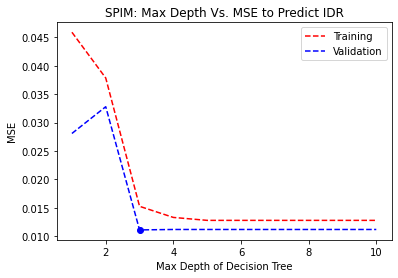

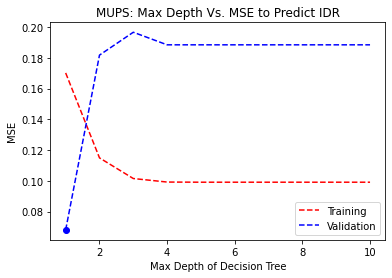

In [13]:
make_graph(spim_train_mse, spim_val_mse, spim_min_val_mse, spim)
make_graph(mups_train_mse, mups_val_mse, mups_min_val_mse, mups)

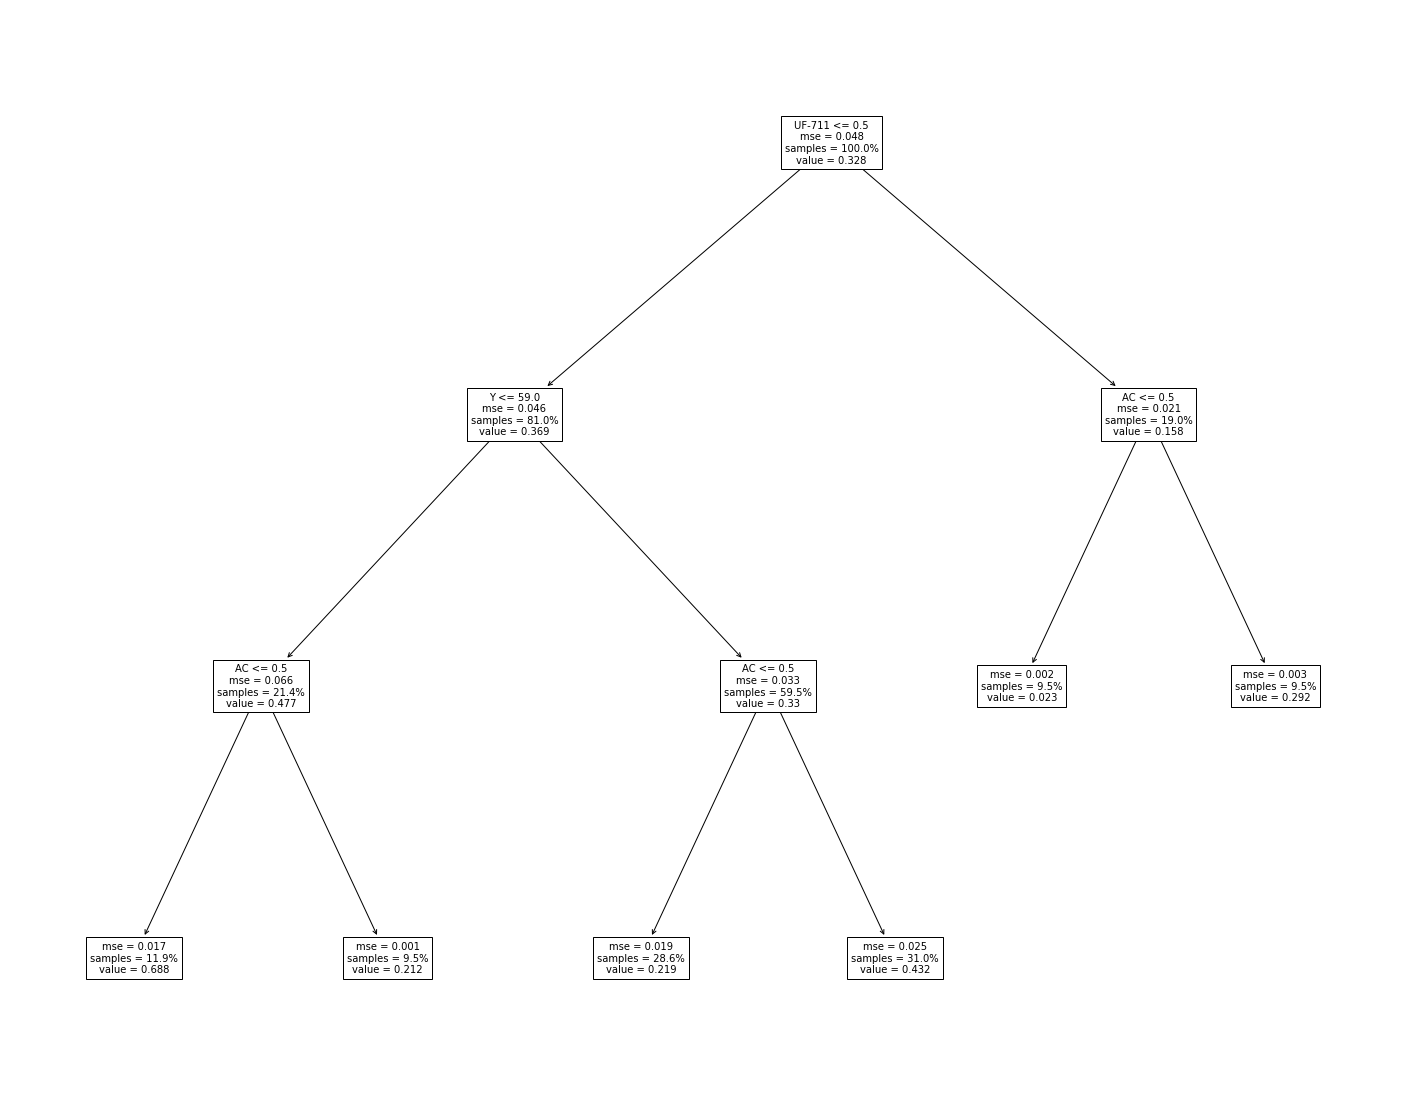

In [14]:
make_tree(spim_min_val_mse, spim)

In [15]:
final_regression = DecisionTreeRegressor(random_state=1, max_depth=3)
final_regression.fit(spim.train_x, spim.train_y)
mse = mean_squared_error(spim.val_y, final_regression.predict(spim.val_x))
print(mse)

0.011111938992194675


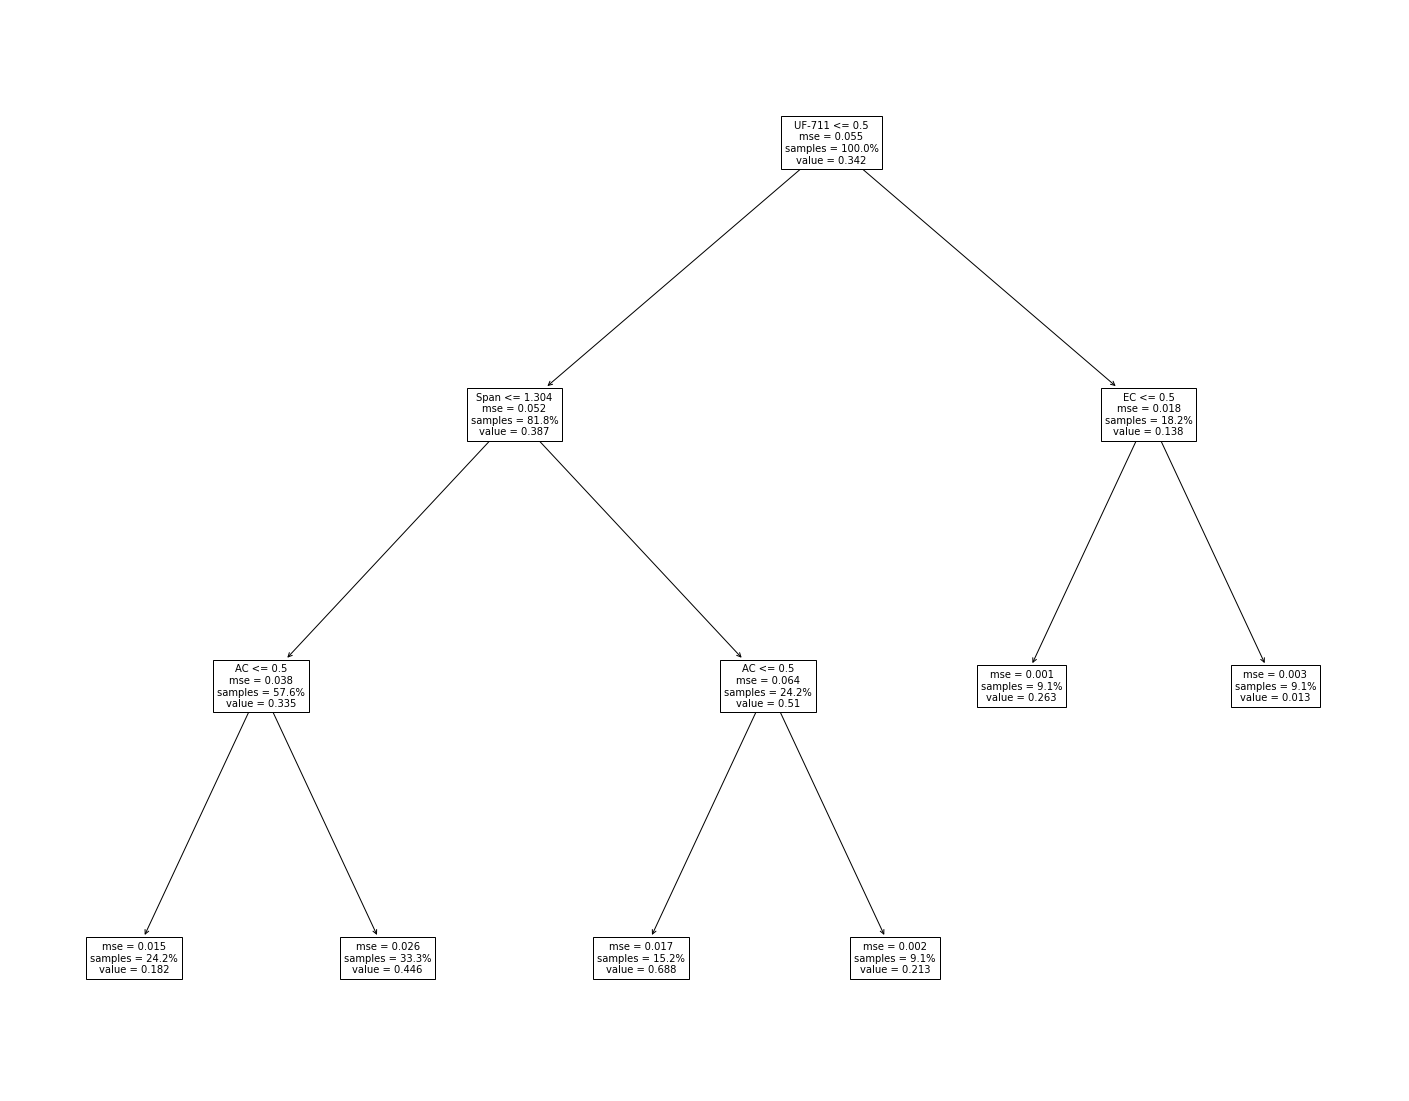

In [16]:
plt.figure(figsize=(25, 20))  # Hard coded for my screen
plot_tree(final_regression, feature_names=spim.x.columns, fontsize=10, proportion=True)
plt.savefig(spim.name + '_tree_dr5.png')
plt.show()